In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

True
1
0
NVIDIA GeForce RTX 3090


'dx' is short for diagnosis (for the patient)
- 'nv': 'Melanocytic nevi'
- 'mel': 'Melanoma'
- 'bkl': 'Benign keratosis-like lesions'
- 'bcc': 'Basal cell carcinoma'
- 'akiec': 'Actinic keratoses'
- 'vasc': 'Vascular lesions'
- 'df': 'Dermatofibroma'

'dx_type' is how the diagnosis was made. 
- histo        5340
- follow_up    3704
- consensus     902
- confocal       69

In [2]:
## Now, we import timm, torchvision image models
!pip install timm # kaggle doesnt have it installed by default
import timm
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss

In [3]:
import pandas as pd
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def disease_to_label(l):
    if l == "akiec":
        return 0
    if l == "bcc":
        return 1
    if l == "bkl":
        return 2
    if l == "df":
        return 3
    if l == "mel":
        return 4
    if l == "nv":
        return 5
    if l == "vasc":
        return 6 

class SkinCancerDetection_train(Dataset):
    
    def __init__(self, train_path, csv, transform=None):
        self.train_path = train_path
        self.csv_path = csv
        self.transform = transform
    def __len__(self):
        df = pd.read_csv(self.csv_path)
        return (len(df.index))
    def __getitem__(self, idx):
        image_id = "ISIC_00" + str(idx+26306)
        image_file_name = image_id + ".jpg"
        df = pd.read_csv(self.csv_path)
        label = disease_to_label(str(df.loc[df['image_id'] == image_id, 'dx'].item()))
        p = os.path.join(self.train_path, image_file_name)

        img = plt.imread(p)


        if self.transform:
            img = self.transform(img)
        
        return img, label
    
class SkinCancerDetection_test(Dataset):
    
    def __init__(self, test_path, csv, transform=None):
        self.test_path = test_path
        self.csv_path = csv
        self.transform = transform
    def __len__(self):
        df = pd.read_csv(self.csv_path)
        return (len(df.index))
    def __getitem__(self, idx):
        image_id = "ISIC_00" + str(idx+24306)
        image_file_name = image_id + ".jpg"
        df = pd.read_csv(self.csv_path)
        label = disease_to_label(str(df.loc[df['image_id'] == image_id, 'dx'].item()))
        
        p = os.path.join(self.test_path, image_file_name)
        
        img = plt.imread(p)
            
        if self.transform:
            img = self.transform(img)
        
        return img, label

In [4]:
train_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter()]), p=0.25),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD), # imagenet means
            transforms.RandomErasing(p=0.1, value='random')
        ])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD) # imagenet means
])

train_ds = SkinCancerDetection_train('../../kaggle/input/HAM10000_images_train_8000','../../kaggle/input/HAM10000_metadata_train_8000.csv',transform=train_transform)
val_ds = SkinCancerDetection_test('../../kaggle/input/HAM10000_images_test_2000','../../kaggle/input/HAM10000_metadata_test_2000.csv',transform=test_transform)

In [5]:
len(val_ds)

2000

## Split train and validation dataset
- batch_size = 64 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>


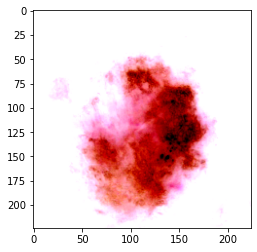

tensor(4)


In [6]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torch.utils.data import DataLoader

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

random_seed = 42
torch.manual_seed(random_seed)

# batch_size = 128
batch_size = 64 

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

plt.figure()

for image, label in train_dl:
    plt.imshow(image[0].permute(2, 1, 0))
    print(type(image[0]))
    plt.show()
    print(label[0])
    break

In [7]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [8]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


In [9]:

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = dots.softmax(dim=-1)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

class CrossAttention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_k = nn.Linear(dim, inner_dim , bias=False)
        self.to_v = nn.Linear(dim, inner_dim , bias = False)
        self.to_q = nn.Linear(dim, inner_dim, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x_qkv):
        b, n, _, h = *x_qkv.shape, self.heads

        k = self.to_k(x_qkv)
        k = rearrange(k, 'b n (h d) -> b h n d', h = h)

        v = self.to_v(x_qkv)
        v = rearrange(v, 'b n (h d) -> b h n d', h = h)

        q = self.to_q(x_qkv[:, 0].unsqueeze(1))
        q = rearrange(q, 'b n (h d) -> b h n d', h = h)



        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = dots.softmax(dim=-1)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out
        
        

import torch
from torch import nn, einsum
import torch.nn.functional as F
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
# from module import Attention, PreNorm, FeedForward, CrossAttention
import numpy as np



class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x


class MultiScaleTransformerEncoder(nn.Module):

    def __init__(self, small_dim = 96, small_depth = 4, small_heads =3, small_dim_head = 32, small_mlp_dim = 384,
                 large_dim = 192, large_depth = 1, large_heads = 3, large_dim_head = 64, large_mlp_dim = 768,
                 cross_attn_depth = 1, cross_attn_heads = 3, dropout = 0.):
        super().__init__()
        self.transformer_enc_small = Transformer(small_dim, small_depth, small_heads, small_dim_head, small_mlp_dim)
        self.transformer_enc_large = Transformer(large_dim, large_depth, large_heads, large_dim_head, large_mlp_dim)

        self.cross_attn_layers = nn.ModuleList([])
        for _ in range(cross_attn_depth):
            self.cross_attn_layers.append(nn.ModuleList([
                nn.Linear(small_dim, large_dim),
                nn.Linear(large_dim, small_dim),
                PreNorm(large_dim, CrossAttention(large_dim, heads = cross_attn_heads, dim_head = large_dim_head, dropout = dropout)),
                nn.Linear(large_dim, small_dim),
                nn.Linear(small_dim, large_dim),
                PreNorm(small_dim, CrossAttention(small_dim, heads = cross_attn_heads, dim_head = small_dim_head, dropout = dropout)),
            ]))

    def forward(self, xs, xl):

        xs = self.transformer_enc_small(xs)
        xl = self.transformer_enc_large(xl)

        for f_sl, g_ls, cross_attn_s, f_ls, g_sl, cross_attn_l in self.cross_attn_layers:
            small_class = xs[:, 0]
            x_small = xs[:, 1:]
            large_class = xl[:, 0]
            x_large = xl[:, 1:]

            # Cross Attn for Large Patch

            cal_q = f_ls(large_class.unsqueeze(1))
            cal_qkv = torch.cat((cal_q, x_small), dim=1)
            cal_out = cal_q + cross_attn_l(cal_qkv)
            cal_out = g_sl(cal_out)
            xl = torch.cat((cal_out, x_large), dim=1)

            # Cross Attn for Smaller Patch
            cal_q = f_sl(small_class.unsqueeze(1))
            cal_qkv = torch.cat((cal_q, x_large), dim=1)
            cal_out = cal_q + cross_attn_s(cal_qkv)
            cal_out = g_ls(cal_out)
            xs = torch.cat((cal_out, x_small), dim=1)

        return xs, xl





class CrossViT(nn.Module):
    def __init__(self, image_size, channels, num_classes, patch_size_small = 14, patch_size_large = 16, small_dim = 96,
                 large_dim = 192, small_depth = 1, large_depth = 4, cross_attn_depth = 1, multi_scale_enc_depth = 3,
                 heads = 3, pool = 'cls', dropout = 0., emb_dropout = 0., scale_dim = 4):
        super().__init__()

        assert image_size % patch_size_small == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches_small = (image_size // patch_size_small) ** 2
        patch_dim_small = channels * patch_size_small ** 2

        assert image_size % patch_size_large == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches_large = (image_size // patch_size_large) ** 2
        patch_dim_large = channels * patch_size_large ** 2
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'


        self.to_patch_embedding_small = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size_small, p2 = patch_size_small),
            nn.Linear(patch_dim_small, small_dim),
        )

        self.to_patch_embedding_large = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size_large, p2=patch_size_large),
            nn.Linear(patch_dim_large, large_dim),
        )

        self.pos_embedding_small = nn.Parameter(torch.randn(1, num_patches_small + 1, small_dim))
        self.cls_token_small = nn.Parameter(torch.randn(1, 1, small_dim))
        self.dropout_small = nn.Dropout(emb_dropout)

        self.pos_embedding_large = nn.Parameter(torch.randn(1, num_patches_large + 1, large_dim))
        self.cls_token_large = nn.Parameter(torch.randn(1, 1, large_dim))
        self.dropout_large = nn.Dropout(emb_dropout)

        self.multi_scale_transformers = nn.ModuleList([])
        for _ in range(multi_scale_enc_depth):
            self.multi_scale_transformers.append(MultiScaleTransformerEncoder(small_dim=small_dim, small_depth=small_depth,
                                                                              small_heads=heads, small_dim_head=small_dim//heads,
                                                                              small_mlp_dim=small_dim*scale_dim,
                                                                              large_dim=large_dim, large_depth=large_depth,
                                                                              large_heads=heads, large_dim_head=large_dim//heads,
                                                                              large_mlp_dim=large_dim*scale_dim,
                                                                              cross_attn_depth=cross_attn_depth, cross_attn_heads=heads,
                                                                              dropout=dropout))

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head_small = nn.Sequential(
            nn.LayerNorm(small_dim),
            nn.Linear(small_dim, num_classes)
        )

        self.mlp_head_large = nn.Sequential(
            nn.LayerNorm(large_dim),
            nn.Linear(large_dim, num_classes)
        )


    def forward(self, img):

        xs = self.to_patch_embedding_small(img)
        b, n, _ = xs.shape

        cls_token_small = repeat(self.cls_token_small, '() n d -> b n d', b = b)
        xs = torch.cat((cls_token_small, xs), dim=1)
        xs += self.pos_embedding_small[:, :(n + 1)]
        xs = self.dropout_small(xs)

        xl = self.to_patch_embedding_large(img)
        b, n, _ = xl.shape

        cls_token_large = repeat(self.cls_token_large, '() n d -> b n d', b=b)
        xl = torch.cat((cls_token_large, xl), dim=1)
        xl += self.pos_embedding_large[:, :(n + 1)]
        xl = self.dropout_large(xl)

        for multi_scale_transformer in self.multi_scale_transformers:
            xs, xl = multi_scale_transformer(xs, xl)
        
        xs = xs.mean(dim = 1) if self.pool == 'mean' else xs[:, 0]
        xl = xl.mean(dim = 1) if self.pool == 'mean' else xl[:, 0]

        xs = self.mlp_head_small(xs)
        xl = self.mlp_head_large(xl)
        x = xs + xl
        return x
    

In [10]:
# import torch
# from crossvit import CrossViT
CrossViT = CrossViT(image_size = 224, channels = 3, num_classes = 7)
model = to_device(CrossViT, device)
model

CrossViT(
  (to_patch_embedding_small): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=14, p2=14)
    (1): Linear(in_features=588, out_features=96, bias=True)
  )
  (to_patch_embedding_large): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
    (1): Linear(in_features=768, out_features=192, bias=True)
  )
  (dropout_small): Dropout(p=0.0, inplace=False)
  (dropout_large): Dropout(p=0.0, inplace=False)
  (multi_scale_transformers): ModuleList(
    (0): MultiScaleTransformerEncoder(
      (transformer_enc_small): Transformer(
        (layers): ModuleList(
          (0): ModuleList(
            (0): PreNorm(
              (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (fn): Attention(
                (to_qkv): Linear(in_features=96, out_features=288, bias=False)
                (to_out): Sequential(
                  (0): Linear(in_features=96, out_features=96, bias=True)
                  (1):

In [11]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = SwinTransformerV2
# model.to(device)

In [12]:
# # model = to_device(ResNet9(3, 7), device)
# # model = to_device(deit_tiny_patch16_224, device)
# model = to_device(SwinTransformerV2, device)
# model

In [13]:
from sklearn.metrics import precision_recall_fscore_support

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def training_step(criterion, model,batch):
    images, labels = batch 
    out = model(images)                  # Generate predictions
    loss = criterion(out, labels)  # criterion is already to device GPU
    return loss

def validation_step(criterion, model,batch):
    images, labels = batch 
    out = model(images)                    # Generate predictions

    loss = criterion(out, labels)   # Calculate loss
    
#     ---------------- why here acc not to(device)
    acc = accuracy(out, labels)           # Calculate accuracy (return a tensor)
    
#     ------------------- calculate fscore for each batch ----------------

    _, y_preds = torch.max(out, dim=1)    
    threeMetrics = precision_recall_fscore_support(torch.Tensor.cpu(labels), torch.Tensor.cpu(y_preds), average=None,labels=[i for i in range(7)])
    fscore = torch.tensor(threeMetrics[2]) # fscore (return a tensor of a list: tensor([1,2,3]))
    
    return {'val_loss': loss.detach(), 'val_acc': acc, 'val_fscore': fscore}
    
def validation_epoch_end(outputs):
    batch_losses = [x['val_loss'] for x in outputs] 
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses (mean loss for n batches)
    
    batch_accs = [x['val_acc'] for x in outputs]   # [ each element is a tensor ]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies (mean acc for n batches)
    
    batch_fscores = [x['val_fscore'] for x in outputs] 
    epoch_fscore = torch.stack(batch_fscores).mean(0)
    
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item(), 'val_fscore': epoch_fscore.tolist()}

def epoch_end(epoch, result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}, val_fscore: {} ".format(
        epoch, result['train_loss'], result['val_loss'], result['val_acc'], result['val_fscore']))

In [14]:
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)

# optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, eps=1e-8, weight_decay=0.05)

In [15]:
@torch.no_grad()
def evaluate(criterion, model, val_loader):
    model.eval()
    outputs = [validation_step(criterion, model, batch) for batch in val_loader]
    return validation_epoch_end(outputs)

def fit_one_cycle(num_epochs, model, train_loader, val_loader, optimizer, criterion):
    torch.cuda.empty_cache()
    history = []
    
    # sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)
    
    for epoch in range(num_epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = training_step(criterion,model,batch)
            train_losses.append(loss)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(criterion, model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()

        epoch_end(epoch, result)
        history.append(result)
    return history

In [16]:
# remove warnings
import warnings
warnings.filterwarnings("ignore")

In [17]:
history = [evaluate(criterion, model, valid_dl)]
history

[{'val_loss': 2.560861587524414,
  'val_acc': 0.04150390625,
  'val_fscore': [0.07635280364411617,
   0.0,
   0.0,
   0.0,
   0.04722939264173581,
   0.0,
   0.013888888888888888]}]

In [18]:
num_epochs=10
history += fit_one_cycle(num_epochs, model, train_dl, valid_dl, optimizer, criterion)

Epoch [0], train_loss: 1.2178, val_loss: 1.1169, val_acc: 0.7072, val_fscore: [0.0, 0.22756158261672968, 0.25864992437062195, 0.0, 0.034970238095238096, 0.836086911780958, 0.0] 
Epoch [1], train_loss: 1.1272, val_loss: 1.0298, val_acc: 0.7152, val_fscore: [0.0, 0.3668520045598051, 0.3645665447929206, 0.0, 0.18640878600243926, 0.8632976130139893, 0.0] 
Epoch [2], train_loss: 1.0785, val_loss: 1.0343, val_acc: 0.7247, val_fscore: [0.0, 0.29268127705627706, 0.43159710971458615, 0.0, 0.052489177489177495, 0.8689221686314552, 0.0625] 
Epoch [3], train_loss: 1.0503, val_loss: 1.0183, val_acc: 0.7249, val_fscore: [0.10223214285714285, 0.10722680097680098, 0.33244371259521577, 0.0, 0.2541494324389061, 0.8558053752819393, 0.16041666666666665] 
Epoch [4], train_loss: 1.0284, val_loss: 0.9675, val_acc: 0.7417, val_fscore: [0.08693910256410256, 0.4286842324342324, 0.39428680531116933, 0.0, 0.07237554112554112, 0.8717343198498116, 0.4772435897435897] 
Epoch [5], train_loss: 1.0109, val_loss: 1.0024

In [19]:
num_epochs=4
history += fit_one_cycle(num_epochs, model, train_dl, valid_dl, optimizer, criterion)

Epoch [0], train_loss: 0.9676, val_loss: 0.9317, val_acc: 0.7584, val_fscore: [0.034722222222222224, 0.42969668124273386, 0.38598109397594527, 0.0, 0.3211872218983287, 0.8857958502336534, 0.5683150183150183] 
Epoch [1], train_loss: 0.9575, val_loss: 0.9047, val_acc: 0.7694, val_fscore: [0.17094155844155845, 0.44141456990721695, 0.4937349476853897, 0.0875, 0.390911653735343, 0.8948481374065984, 0.6289624183006537] 
Epoch [2], train_loss: 0.9381, val_loss: 0.9038, val_acc: 0.7704, val_fscore: [0.3198142135642136, 0.4859313679311744, 0.49438020106367675, 0.0, 0.44547719792285, 0.899977769665795, 0.548076923076923] 
Epoch [3], train_loss: 0.9370, val_loss: 0.9052, val_acc: 0.7786, val_fscore: [0.10654761904761906, 0.40217231706202294, 0.4845581283970086, 0.07291666666666666, 0.32070498945498943, 0.8959767650487631, 0.6552083333333333] 


In [20]:
# num_epochs=2
# history += fit_one_cycle(num_epochs, model, train_dl, valid_dl, optimizer, criterion)

In [21]:
# num_epochs=2
# history += fit_one_cycle(num_epochs, model, train_dl, valid_dl, optimizer, criterion)

In [22]:
# torch.save(model.state_dict(), 'deit_tiny_patch16_224.pth')
torch.save(model.state_dict(), '../../kaggle/ubuntu_save_model/ubuntu_sourceCode_size82_crossvit.pth')

In [23]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

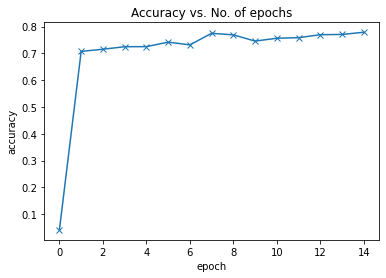

In [24]:
plot_accuracies(history)

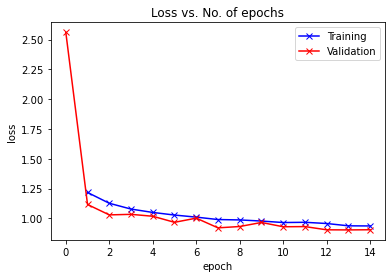

In [25]:
plot_losses(history)